In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import numpy as np
import pandas as pd

import SequenceDataORM as sqd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///NS001_evolved_mutations_copy2.db', echo=False) # our database connection
session = sessionmaker(bind=engine)() # the session object is how we make queries through sqlalchemy

# What are the mutations that occur in the ancestor?

Any polymorphisms that were present in NS001 were initiall present in the evolving populations so we expect to see them a lot. By looking at these mutations across the replicate populations, we may be able to better understand the founding NS001 population.

In [3]:
ancestral_snps = [snp for snp in session.query(sqd.SNP_Mutation)
                  if ('Aggregate_NS001_Ancestors' in snp.samples) or
                     ('Ancestor_S1' in snp.samples) or
                     ('Ancestor_S2' in snp.samples) or
                     ('Ancestor_S3' in snp.samples)]
print('There are {0} snps found in the ancestor NS001.'.format(len(ancestral_snps)))

There are 63 snps found in the ancestor NS001.


Mutations that occur only once or twice out of all the samples are pretty sketchy for trying to understand the population substructure of the original NS001 population. So let's get rid of all of those.

In [4]:
common_snps = [snp for snp in ancestral_snps if len(snp.samples) >2]
print('There are {0} common snps found in the ancestor and multiple descendants.'.format(len(common_snps)))

There are 25 common snps found in the ancestor and multiple descendants.


Maybe our cutoff should be higher than two. How many samples have each of the mutations we're dealing with now?

In [5]:
for snp in common_snps:
    print(snp, len(snp.samples))

<SNP_Mutation(chr_position=102236, ref_base=A, new_base=G, gene=murC|ddlB)> 27
<SNP_Mutation(chr_position=155269, ref_base=T, new_base=C, gene=htrE)> 20
<SNP_Mutation(chr_position=327888, ref_base=A, new_base=G, gene=betB)> 12
<SNP_Mutation(chr_position=419369, ref_base=T, new_base=C, gene=brnQ)> 17
<SNP_Mutation(chr_position=547336, ref_base=C, new_base=T, gene=fdrA)> 18
<SNP_Mutation(chr_position=1055424, ref_base=A, new_base=T, gene=torS/torT)> 15
<SNP_Mutation(chr_position=1171667, ref_base=A, new_base=G, gene=mfd)> 14
<SNP_Mutation(chr_position=1541878, ref_base=A, new_base=G, gene=narZ/narU)> 12
<SNP_Mutation(chr_position=1733676, ref_base=T, new_base=C, gene=mepH)> 12
<SNP_Mutation(chr_position=1851805, ref_base=T, new_base=C, gene=pncA/ydjE)> 17
<SNP_Mutation(chr_position=2747257, ref_base=G, new_base=A, gene=ffh)> 16
<SNP_Mutation(chr_position=3089230, ref_base=T, new_base=C, gene=galP)> 13
<SNP_Mutation(chr_position=3437557, ref_base=A, new_base=G, gene=trkA)> 27
<SNP_Mutatio

The smallest number of samples left that a "common" ancestral mutation was detected in is now 4 and most are well past that so we'll stick with these 25 mutations for analyzing population substructure.

# What are their frequencies in all samples and how well are different mutations frequencies correlated?

If the frequency of two mutations remains correlated across a wide range of samples, the most plausible explanation is that those mutations occurred in the same lineage of the founding NS001 population (probably on the plate where the colony was first picked after transformation even).

By looking at correlations between mutation frequencies, we can attempt to group mutations into lineages and sublineages.

In [6]:
all_samples = [sample for sample in session.query(sqd.DNA_Sample)]
all_samples = all_samples[1:] + [all_samples[0]]

common_snp_frequencies = np.zeros(shape=(len(all_samples),len(common_snps)),dtype='float')

for i, sample in enumerate(all_samples):
    for j, snp in enumerate(common_snps):
        common_snp_frequencies[i,j] = sample.snp_mutation_frequency(snp, session)

common_snp_frequencies_df = pd.DataFrame(data=common_snp_frequencies,
                                  index=[sample.name for sample in all_samples],
                                  columns=[(snp.gene, snp.chr_position) for snp in common_snps])

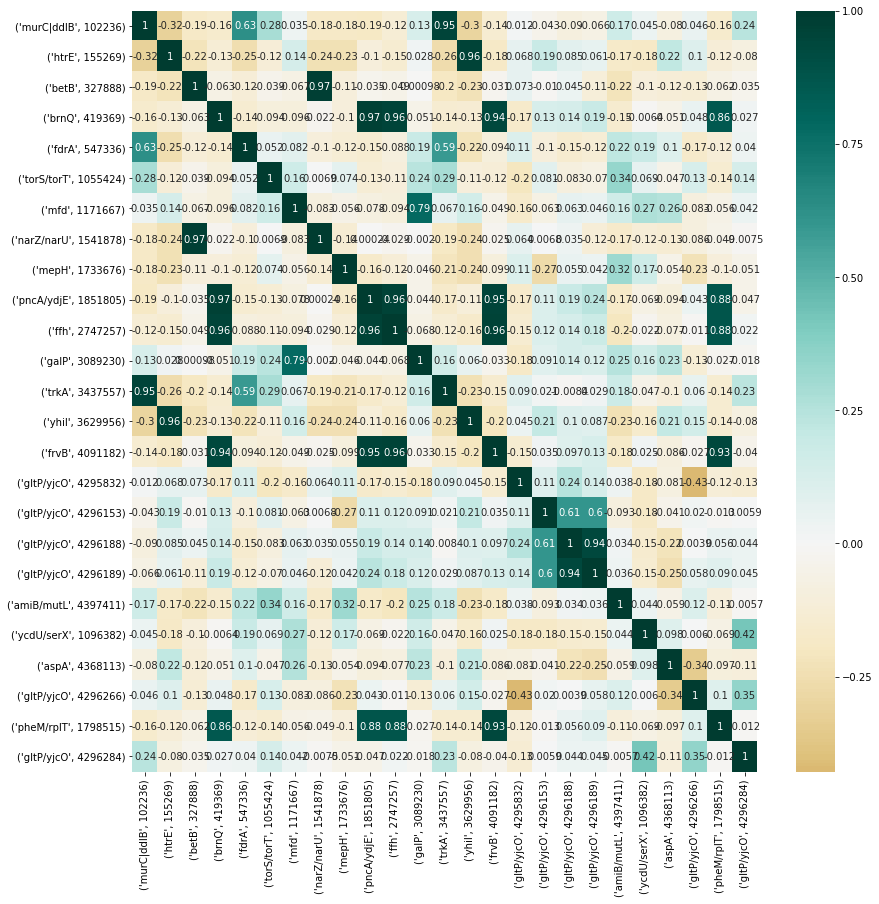

In [7]:
plt.figure(figsize=(14,14))
sns.heatmap(common_snp_frequencies_df.corr(), center=0, cmap='BrBG', annot=True)

After eyeballing this in another notebook, I have a rough idea of which SNP's group together. Rearranging to make highly correlated SNP's group together.

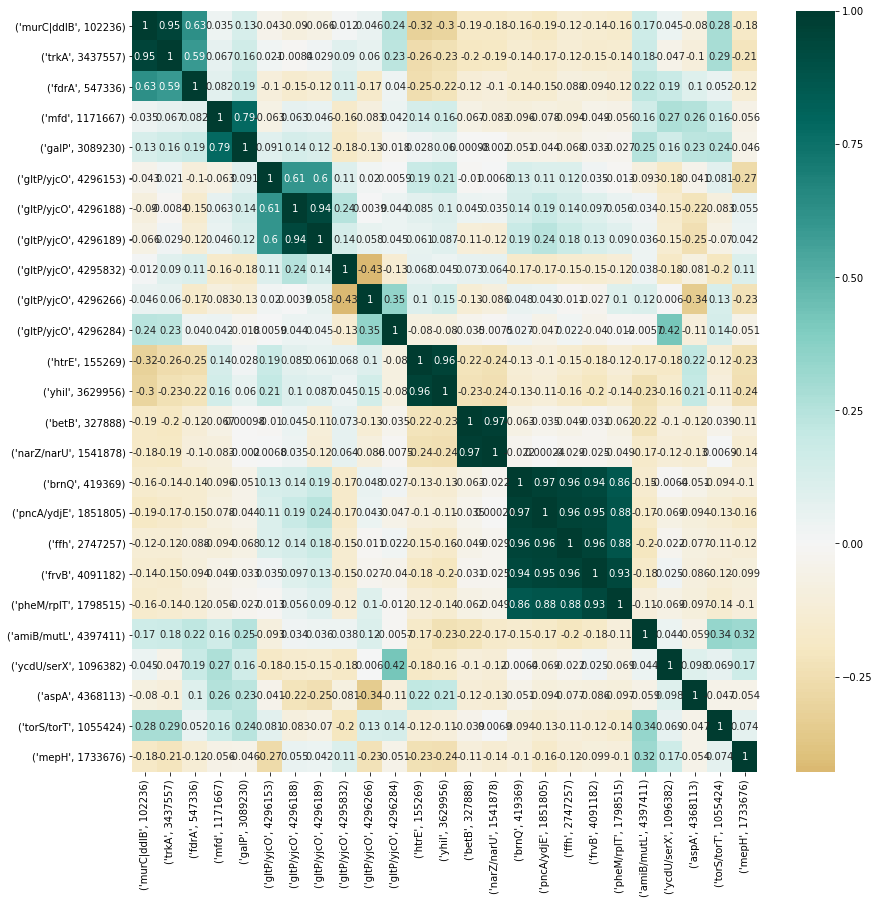

In [8]:
arrangement= [0,12,4,6,11,16,17,18,15,22,24,1,13,2,7,3,9,10,14,23,19,20,21,5,8]
common_snp_corr_rearranged = common_snp_frequencies_df.corr().values[arrangement][:,arrangement]
common_snp_corr_df_ra = pd.DataFrame(data=common_snp_corr_rearranged,
                                     index=common_snp_frequencies_df.columns[arrangement],
                                     columns=common_snp_frequencies_df.columns[arrangement])
plt.figure(figsize=(14,14))
sns.heatmap(common_snp_corr_df_ra, center=0, cmap='BrBG', annot=True)

# What does this imply about the evolutionary tree the ancestral mutations were in?

Now you can clearly see that many (although not all) mutations occur in very well correlated groups. Often, all correlations are >.9. These groups likely correspond to subpopulations of the original population.

An obvious hypothesis is that these mutations occurred in sequence during cell divisions from the founding cell of all NS001 (or even during a single cell division) and that any relatives without the full cluster of mutations were lost to population drift. If we follow this hypothesis, what does the evolutionary tree look like?

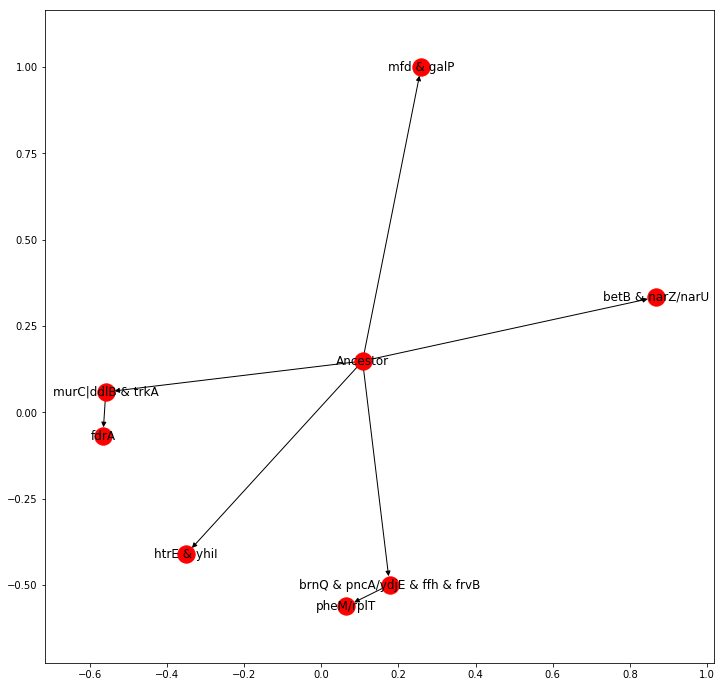

In [9]:
# TODO Figure out how to make nice tree graphics
import networkx as nwx

plt.figure(figsize=(12,12))

Tree1 = nwx.DiGraph()
node_list = ['Ancestor', 'murC|ddlB & trkA', 'fdrA', 'mfd & galP', 'htrE & yhiI',
                      'betB & narZ/narU', 'brnQ & pncA/ydjE & ffh & frvB', 'pheM/rplT']
Tree1.add_nodes_from(node_list)
for i in [1, 3, 4, 5, 6]:
    Tree1.add_edge(node_list[0], node_list[i])
Tree1.add_edge(node_list[1], node_list[2])
Tree1.add_edge(node_list[6], node_list[7])
nwx.draw_networkx(Tree1)

# Some problems

When you compare our guess about how the evolutionary tree the ancestral mutations occurred on with the gene frequencies in the ancestral population, you get that the subpopulations frequencies add up to more than 1. This is impossible, so either those frequencies are off enough that the problem isn't real (possible) or some of these subpopulations should actually be a subpopulation of another subpopulation.

# Is there a good way to estimate the effects of the ancestral mutations on fitness?

One question we can ask is on the final day, how many times did an ancestral mutation fix and how many times did a nonancestral mutation fix?

We'll only consider the samples from the last day sequenced to simplify things.

In [10]:
samples_with_fixations = [sample for sample in (session.query(sqd.SNP_Evidence)
                                                .filter(sqd.SNP_Evidence.frequency==1)
                                                .filter(sqd.SNP_Evidence.sample.like('%t1%')))]

In [11]:
for sm in samples_with_fixations:
    print(sm)

<SNP_Evidence(sample=Hi1t1_S1, chr_position=4437631, ref_base=T, new_base=C)>
<SNP_Evidence(sample=Hi2t1_S1, chr_position=1129879, ref_base=A, new_base=G)>
<SNP_Evidence(sample=Hi3t1_S1, chr_position=4437631, ref_base=T, new_base=C)>
<SNP_Evidence(sample=HiMid2t1_S1, chr_position=4437631, ref_base=T, new_base=C)>
<SNP_Evidence(sample=HiMid3t1_S1, chr_position=1541878, ref_base=A, new_base=G)>
<SNP_Evidence(sample=HiMid4t1_S1, chr_position=1055424, ref_base=A, new_base=T)>
<SNP_Evidence(sample=Mid2t1_S1, chr_position=4437631, ref_base=T, new_base=C)>
<SNP_Evidence(sample=Mid3t1_S1, chr_position=1733676, ref_base=T, new_base=C)>
<SNP_Evidence(sample=Mid4t1_S1, chr_position=4437631, ref_base=T, new_base=C)>
<SNP_Evidence(sample=LoMid2t1_S1, chr_position=3802148, ref_base=C, new_base=T)>
<SNP_Evidence(sample=LoMid3t1_S1, chr_position=1295680, ref_base=A, new_base=G)>
<SNP_Evidence(sample=LoMid3t1_S1, chr_position=1641157, ref_base=C, new_base=T)>
<SNP_Evidence(sample=LoMid3t1_S1, chr_posit

In [12]:
ans = (session.query(sqd.SNP_Evidence)
 .filter(sqd.SNP_Evidence.sample.in_(['Aggregate_NS001_Ancestors','Ancestor_S1', 'Ancestor_S2','Ancestor_S3']))
 .filter(sqd.SNP_Evidence.chr_position==1733676))

In [13]:
for x in ans:
    print(x)

<SNP_Evidence(sample=Aggregate_NS001_Ancestors, chr_position=1733676, ref_base=T, new_base=C)>
<SNP_Evidence(sample=Ancestor_S1, chr_position=1733676, ref_base=T, new_base=C)>
<SNP_Evidence(sample=Ancestor_S2, chr_position=1733676, ref_base=T, new_base=C)>


In [14]:
cysQ_mutation = session.query(sqd.SNP_Mutation).filter(sqd.SNP_Mutation.chr_position==4437631).first()

In [15]:
cysQ_mutation.samples

['Hi1t1_S1', 'Hi3t1_S1', 'HiMid2t1_S1', 'HiMid2t2_S1', 'Lo2t1_S1', 'Lo2t2_S1', 'Lo3t1_S1', 'Lo4t1_S1', 'LoMid1t2_S1', 'LoMid2t2_S1', 'LoMid3t2_S1', 'Mid2t1_S1', 'Mid4t1_S1', 'Mid4t2_S1']

In [16]:
common_mutations = [mut for mut in session.query(sqd.SNP_Mutation) if len(mut.samples)>3]

In [17]:
len(common_mutations)

41

In [18]:
nonancestral_common_mutations = [mut for mut in common_mutations if ('Aggregate_NS001_Ancestors' not in mut.samples)
                                 and ('Ancestor_S1' not in mut.samples) and ('Ancestor_S2' not in mut.samples) and
                                 ('Ancestor_S3' not in mut.samples)]

In [19]:
len(nonancestral_common_mutations)

16

In [20]:
for mut in nonancestral_common_mutations:
    print(mut, len(mut.samples), mut.synonymous)

<SNP_Mutation(chr_position=339961, ref_base=C, new_base=T, gene=yahI)> 4 True
<SNP_Mutation(chr_position=3018616, ref_base=T, new_base=C, gene=ygfK)> 4 False
<SNP_Mutation(chr_position=4437631, ref_base=T, new_base=C, gene=cysQ/ytfI)> 14 True
<SNP_Mutation(chr_position=4859, ref_base=A, new_base=G, gene=thrC)> 5 False
<SNP_Mutation(chr_position=1207577, ref_base=G, new_base=A, gene=tfaP)> 4 False
<SNP_Mutation(chr_position=1589442, ref_base=T, new_base=C, gene=ydeT/yneL)> 8 True
<SNP_Mutation(chr_position=1760934, ref_base=G, new_base=A, gene=sufD)> 9 False
<SNP_Mutation(chr_position=1958386, ref_base=G, new_base=C, gene=cutC)> 8 True
<SNP_Mutation(chr_position=1042617, ref_base=T, new_base=C, gene=etk)> 6 False
<SNP_Mutation(chr_position=1755400, ref_base=T, new_base=C, gene=pykF)> 5 False
<SNP_Mutation(chr_position=95476, ref_base=C, new_base=T, gene=murF)> 8 False
<SNP_Mutation(chr_position=524183, ref_base=T, new_base=C, gene=rhsD)> 7 False
<SNP_Mutation(chr_position=528733, ref_ba

In [21]:
nonancestral_common_mutations[2].intergenic_right

-76

In [22]:
nonancestral_common_mutations[13].synonymous

True